In [1]:
import re
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import nltk

from IPython.core.display import display, HTML
from nltk.corpus import stopwords
from collections import defaultdict
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

nltk.download("stopwords")


/var/folders/nh/40rdrc796pq8z5wlh1jvk9rwp0h31q/T/ipykernel_16710/475472021.py:17: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/20793788/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Import Data

In [2]:
train = pd.read_csv("train.csv")
print(train.shape)
train.head()


(8050, 4)


,movie_name,target,movie_description,id
0,Furies,0,Three furious vigilantes unite to take down a ...,133529636342330622371894152500993949030
1,RRR,0,The story of freedom fighters Komaram Bheem an...,133529660110779376651195430564179049830
2,John Wick,0,Legendary assassin John Wick (Keanu Reeves) re...,133529680710101630359923204885606137190
3,John Wick: Chapter 3 -- Parabellum,0,After gunning down a member of the High Table ...,133529687048354631501070212369122164070
4,Top Gun: Maverick,0,After more than thirty years of service as one...,133529699724860633783364227336154217830


In [3]:
test = pd.read_csv("test.csv")
print(test.shape)
test.head()


(2684, 3)


,movie_name,movie_description,id
0,All Quiet on the Western Front,All Quiet on the Western Front tells the gripp...,133529667241314002934985813983134580070
1,Black Panther: Wakanda Forever,"In Marvel Studios' ""Black Panther: Wakanda For...",133529693386607632642217219852638190950
2,Interstellar,"In Earth's future, a global crop blight and se...",133529737754378640630246272237250379110
3,Avengers: Endgame,"Adrift in space with no food or water, Tony St...",133529756769137644053687294687798459750
4,Uncharted,Street-smart thief Nathan Drake (Tom Holland) ...,133529828866765532034234504812793265510


## Target Distributions

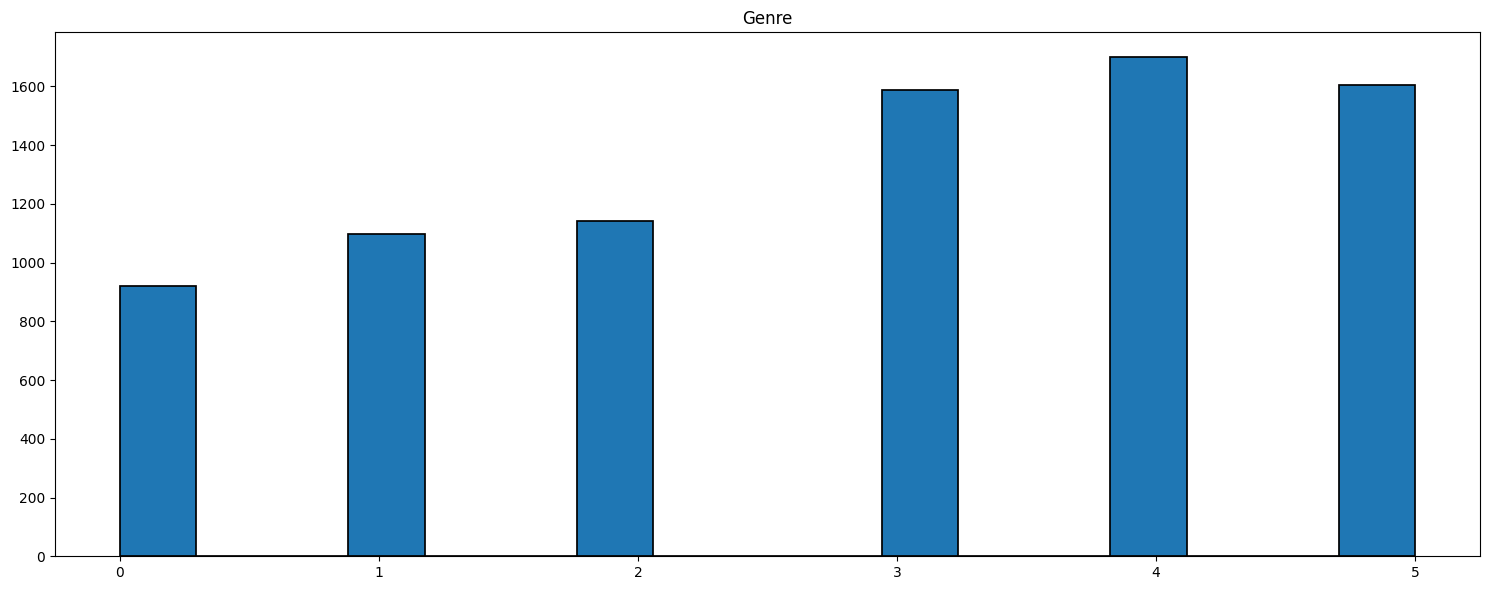

In [4]:
fig, axes = plt.subplots(1, 1, figsize=(15, 6))

sns.histplot(x="target", data=train, linewidth=1.25,
             alpha=1, ax=axes, zorder=2)
axes.set_title("Genre")
axes.set(xlabel=None, ylabel=None)

plt.tight_layout()
plt.show()


### (As a percentage)

In [5]:
print(train.target.value_counts(normalize=True))


4    0.211056
5    0.199503
3    0.197391
2    0.141615
1    0.136149
0    0.114286
Name: target, dtype: float64


## Number words

In [6]:
print("Number words in train dataset: ", len(
    " ".join(train.movie_description.tolist()).split()))
print("Number words in test dataset: ", len(
    " ".join(test.movie_description.tolist()).split()))


Number words in train dataset:  444069
Number words in test dataset:  148594


## Vocabulary size

In [7]:
vocab_size = len(set(" ".join(train.movie_description.tolist()).split(
) + " ".join(test.movie_description.tolist()).split()))
print("Vocabulary size: ", vocab_size)


Vocabulary size:  58295


## Movie Description Example

In [8]:
def print_texts(df):
    inner_html = ""
    for idx, row in df.iterrows():
        inner_html += f"""
        <td style="vertical-align:top; border-right: 1px solid #7accd8">
        <h3 style="text-align:left">{row.movie_name}</h3>
        <hr>
            <dl>
                <dt> Genre </dt>
                <dd>{row.target}</dd>
            </dl>
            
            <hr>
            <p>
            {row.movie_description}
            </p>
        </td>
        """
    display(HTML(f"""
    <table style="font-family: monospace;">
        <tr>
             {inner_html}
        </tr>
    </table>
    """))


In [9]:
horror_genre = train[train.target == 0].head(2)
print_texts(horror_genre)


Furies Genre 0 Three furious vigilantes unite to take down a sinister crime syndicate that controls the mean streets of 1990s Saigon.,RRR Genre 0 The story of freedom fighters Komaram Bheem and Alluri Sitarama Raju.


In [10]:
comedy_genre = train[train.target == 1].head(2)
print_texts(comedy_genre)


"We Lost Our Human Genre 1 An interactive comedy adventure about two indoor pets, a cat named Pud and a dog named Ham, who wake up one day to find that all humans have seemingly disappeared from planet Earth.","Everything Everywhere All at Once Genre 1 Directed by Daniel Kwan and Daniel Scheinert, collectively known as Daniels, the film is a hilarious and big-hearted sci-fi action adventure about an exhausted Chinese American woman (Michelle Yeoh) who can't seem to finish her taxes."


## Text Analysis

### Number of Characters

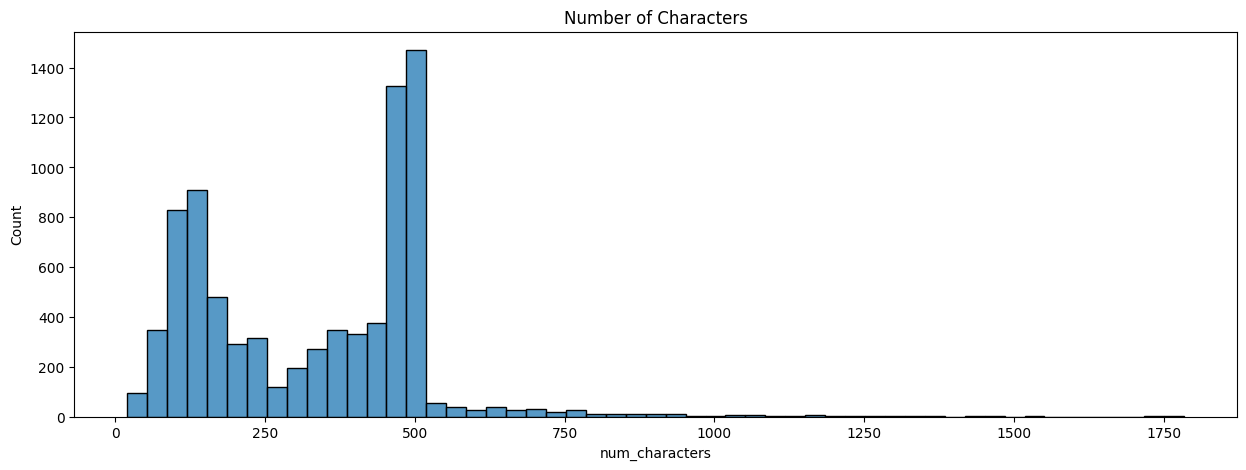

In [11]:
fig = plt.figure(figsize=(15, 5))
train["num_characters"] = train["movie_description"].str.len()

sns.histplot(data=train, x="num_characters")
plt.title("Number of Characters")
plt.show()


In [12]:
fig = px.histogram(
    train,
    x=train["movie_description"].str.len(),
    marginal="box",
    title="Number of Characters",
    color_discrete_sequence=["#FFA200"]
)
fig.update_layout(bargap=0.2)
fig.update_layout(template="plotly_dark", font=dict(
    family="PT Sans", size=18, color="#C4FEFF"))
fig.show()


### Number of Words

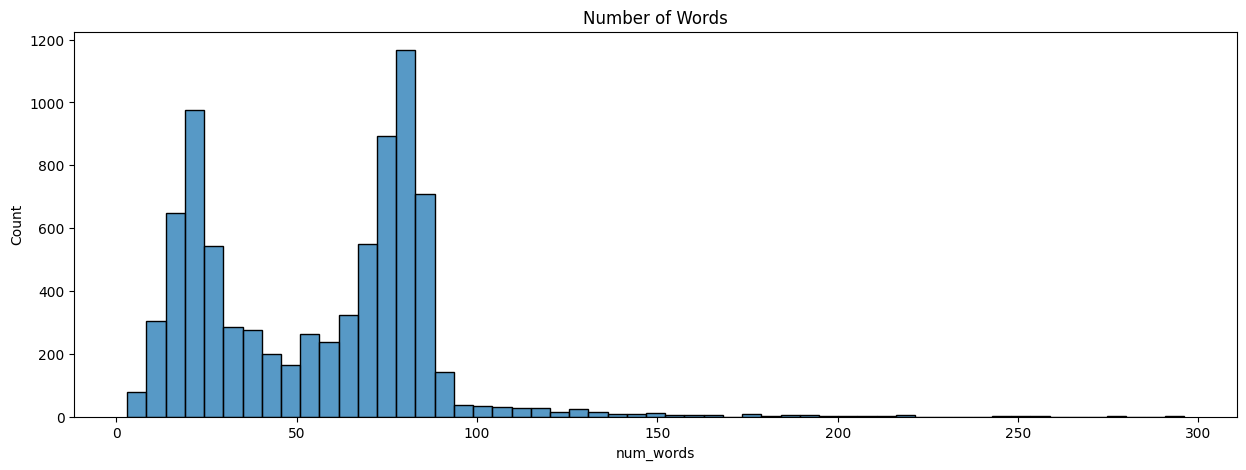

In [13]:
fig = plt.figure(figsize=(15, 5))
train["num_words"] = train["movie_description"].apply(
    lambda x: len(str(x).split()))
sns.histplot(data=train, x="num_words")
plt.title("Number of Words")
plt.show()


In [14]:
fig = px.histogram(
    train,
    x=train["num_words"],
    marginal="box",
    title="Number of Words",
    color_discrete_sequence=["#FFA200"]
)
fig.update_layout(bargap=0.2)
fig.update_layout(template="plotly_dark", font=dict(
    family="PT Sans", size=18, color="#C4FEFF"))
fig.show()


In [15]:
train["num_words"].describe()


count    8050.000000
mean       55.163851
std        30.783969
min         3.000000
25%        25.000000
50%        62.000000
75%        79.000000
max       296.000000
Name: num_words, dtype: float64

### Common Stopwords

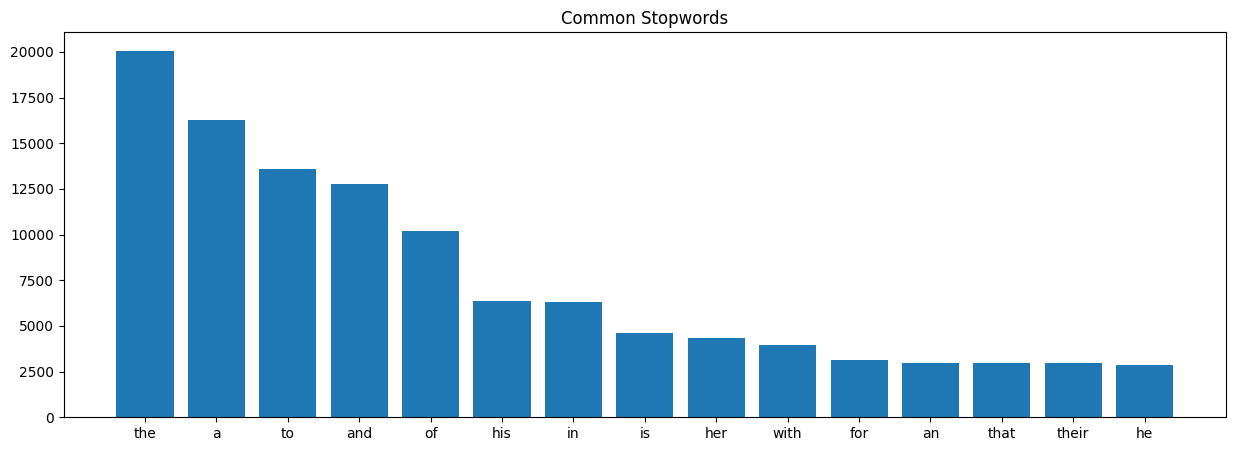

In [16]:
fig = plt.figure(figsize=(15, 5))

stop_words = set(stopwords.words("english"))
corpus = "".join(map(str, train.movie_description)).split()

dic = defaultdict(int)
for word in corpus:
    if word in stop_words:
        dic[word] += 1
top_words = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:15]
x, y = zip(*top_words)
plt.bar(x, y)
plt.title("Common Stopwords")
plt.show()


### Word Cloud

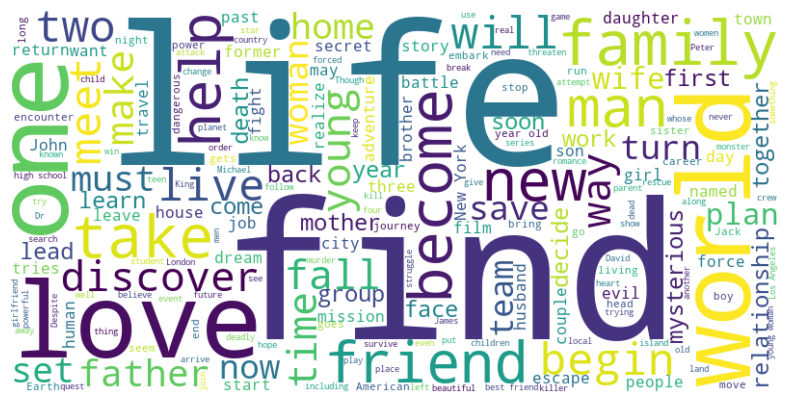

In [17]:
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(
    "".join(map(str, train.movie_description)))

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
